Доржиев А.С. АБД19-1М

вместо logReg - другой алгоритм взять

БД для русского языка - Юлия Рубцова nlp dataset

# Задание 

* Обучите классификаторы на всей базе данных
* В качестве классификаторов подберите оптимальные модели:
* Машинное обучение (не лог регрессия), многослойный персептрон, сверточная сеть, рекуррентная сеть
* Постройте графики, продемонстрируйте работу классификаторов на любых предложениях, не содержащихся в бд, но состоящие из слов полного словаря.
* Проведите сравнительный анализ классификаторов
* Найдите русскоязычную размеченную БД для обучения классификаторов и сравните модели для классификации отзывов на русском языке

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, average_precision_score, roc_curve
from sklearn.model_selection import GridSearchCV

In [ ]:
PATH = "/content/drive/My Drive/Нейронные сети 1_Модуль_2020"

In [ ]:
filepath_dict = {'yelp':   PATH+'/sentiment labelled sentences/yelp_labelled.txt',
                 'amazon': PATH+'/sentiment labelled sentences/amazon_cells_labelled.txt',
                 'imdb':   PATH+'/sentiment labelled sentences/imdb_labelled.txt'}

In [ ]:
filepath_dict

{'amazon': '/content/drive/My Drive/Нейронные сети 1_Модуль_2020/sentiment labelled sentences/amazon_cells_labelled.txt',
 'imdb': '/content/drive/My Drive/Нейронные сети 1_Модуль_2020/sentiment labelled sentences/imdb_labelled.txt',
 'yelp': '/content/drive/My Drive/Нейронные сети 1_Модуль_2020/sentiment labelled sentences/yelp_labelled.txt'}

In [ ]:
df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source 
    df_list.append(df)

In [ ]:
df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


In [ ]:
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


In [ ]:
# Проверим баланс классов
df['label'].value_counts()

1    1386
0    1362
Name: label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

#### Построим проверочную простую модель

In [ ]:
df_yelp = df[df['source'] == 'imdb']

In [ ]:
sentences = df_yelp['sentence'].values

In [ ]:
df_yelp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 748 entries, 0 to 747
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  748 non-null    object
 1   label     748 non-null    int64 
 2   source    748 non-null    object
dtypes: int64(1), object(2)
memory usage: 23.4+ KB


In [ ]:
y = df_yelp['label'].values

In [ ]:
sentences_train, sentences_test, y_train, y_test = train_test_split( sentences, y, test_size=0.25, random_state=1000)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<561x2505 sparse matrix of type '<class 'numpy.int64'>'
	with 8413 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
classifier = RandomForestClassifier(random_state=17)
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.7058823529411765


### Классификатор RandomForest. Обучение на всей БД 

In [ ]:
sentences = df['sentence'].values

In [ ]:
y = df['label'].values

In [ ]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=17)

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train



<2061x4250 sparse matrix of type '<class 'numpy.int64'>'
	with 22208 stored elements in Compressed Sparse Row format>

In [ ]:
rfc_cl = RandomForestClassifier(random_state=17, max_depth=5)
rfc_cl.fit(X_train, y_train)
score = rfc_cl.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.7292576419213974


#### Графики модели

In [ ]:
def get_scores(model, X, y): 
  y_pred = model.predict_proba(X)[:,1]
  p_score, r_score, thresholds = precision_recall_curve(y, y_pred)
  f_score = (2 * p_score * r_score) / (p_score + r_score)
  idx = np.argmax(f_score)
  threshold = thresholds[idx]

  plt.figure(figsize=(5,5))
  plt.plot(r_score, p_score)
  plt.plot(r_score[idx], p_score[idx], marker=".", markersize=12, color='r')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  t = plt.title('Оптимальный порог = {:.2f}'.format(threshold))

  print('Average precision_recall score: {:.2f}'.format(average_precision_score(y, y_pred)))
  print('ROC-AUC score: {:.2f}'.format(roc_auc_score(y, y_pred)))

In [ ]:
def get_conf_matrix(y, y_pred): 
  data = {'y_actual': y, 'y_predicted': y_pred}
  df_cm = pd.DataFrame(data, columns=['y_actual', 'y_predicted'])
  cm = pd.crosstab(df_cm['y_actual'], df_cm['y_predicted'], rownames=['Actual'], colnames=['Predicted'])
  sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
def get_roc_auc(y, y_pred_proba, model_name, data_type):
  plt.figure(figsize=(5,5)) 
  fpr, tpr, _ = roc_curve(y, y_pred_proba)
  plt.plot(fpr, tpr, label=model_name)
  plt.plot([0,1], [0,1])
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.legend()
  t = plt.title('ROC-AUC curve.'+data_type)

  print('ROC-AUC score: {:.2f}'.format(roc_auc_score(y, y_pred_proba)))

#### train data 

Average precision_recall score: 0.93
ROC-AUC score: 0.92


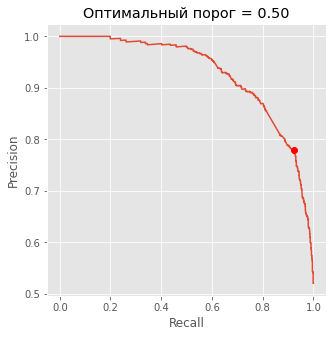

In [ ]:
get_scores(rfc_cl, X_train, y_train)

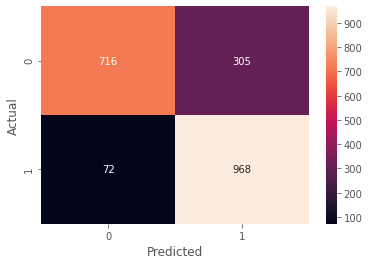

In [ ]:
get_conf_matrix(y_train, rfc_cl.predict(X_train))

ROC-AUC score: 0.92


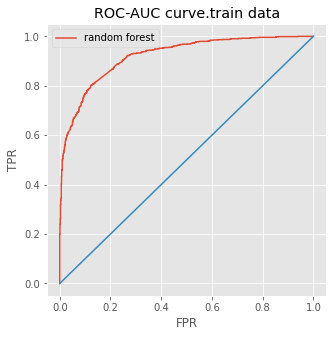

In [ ]:
get_roc_auc(y_train, rfc_cl.predict_proba(X_train)[:,1], 'random forest', 'train data')

#### test data

Average precision_recall score: 0.85
ROC-AUC score: 0.84


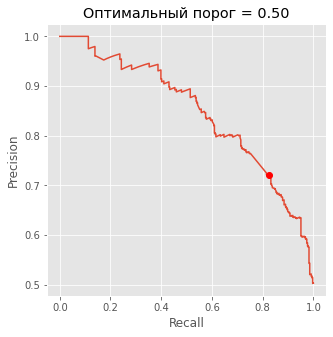

In [ ]:
get_scores(rfc_cl, X_test, y_test)

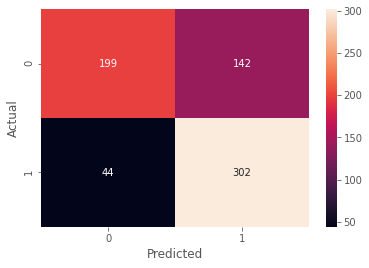

In [ ]:
get_conf_matrix(y_test, rfc_cl.predict(X_test))

ROC-AUC score: 0.84


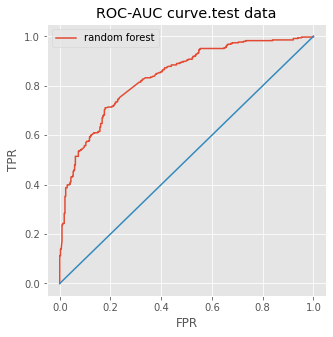

In [ ]:
get_roc_auc(y_test, rfc_cl.predict_proba(X_test)[:,1], 'random forest', 'test data')

## Предсказание Random Forest

In [ ]:
my_sentences = ['the match was great', 'it is the worst trip in my life']
d = vectorizer.transform(my_sentences).toarray()

In [ ]:
my_sentences

['the match was great', 'it is the worst trip in my life']

In [ ]:
rfc_cl.predict(d)

array([1, 0])

In [ ]:
result_rfr = pd.DataFrame({'sentence': my_sentences, 
                      'result': rfc_cl.predict(d)
              })

In [ ]:
result_rfr

,sentence,result
0,the match was great,1
1,it is the worst trip in my life,0


# Классификаторы НС1

In [ ]:
import tensorflow
import keras

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD 
from keras.utils import np_utils

In [ ]:
callbacks_list = [
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
        keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10)  
]

In [ ]:
input_dim = X_train.shape[1]

model1 = Sequential()
model1.add(Dense(10, input_dim=input_dim, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

In [ ]:
model1.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                42510     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 42,521
Trainable params: 42,521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model1.fit(X_train, y_train, 
                    epochs=100,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                    callbacks=callbacks_list)

Epoch 1/100
207/207 [==============================] - 1s 4ms/step - loss: 0.6682 - accuracy: 0.6851 - val_loss: 0.6298 - val_accuracy: 0.7598
Epoch 2/100
207/207 [==============================] - 1s 3ms/step - loss: 0.5193 - accuracy: 0.8607 - val_loss: 0.5267 - val_accuracy: 0.7904
Epoch 3/100
207/207 [==============================] - 1s 3ms/step - loss: 0.3472 - accuracy: 0.9292 - val_loss: 0.4823 - val_accuracy: 0.8137
Epoch 4/100
207/207 [==============================] - 1s 3ms/step - loss: 0.2395 - accuracy: 0.9534 - val_loss: 0.4682 - val_accuracy: 0.8122
Epoch 5/100
207/207 [==============================] - 1s 3ms/step - loss: 0.1730 - accuracy: 0.9704 - val_loss: 0.4724 - val_accuracy: 0.8311
Epoch 6/100
207/207 [==============================] - 1s 3ms/step - loss: 0.1299 - accuracy: 0.9787 - val_loss: 0.4872 - val_accuracy: 0.8253
Epoch 7/100
207/207 [==============================] - 1s 3ms/step - loss: 0.1004 - accuracy: 0.9874 - val_loss: 0.5149 - val_accuracy: 0.8210

## Результаты

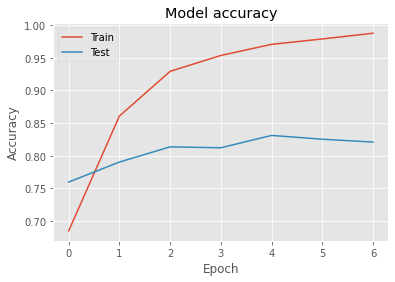

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) 
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

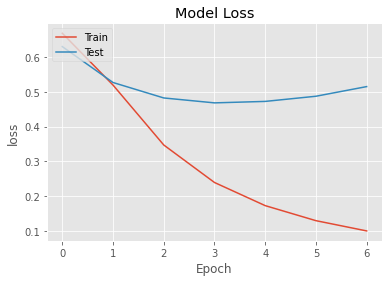

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4}".format(accuracy))
loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy: {:.4}".format(accuracy))

Training Accuracy: 0.9918
Test Accuracy: 0.821


In [ ]:
def get_scores_NN(model, X, y): 
  y_pred = model.predict_proba(X)[:,0]
  p_score, r_score, thresholds = precision_recall_curve(y, y_pred)
  f_score = (2 * p_score * r_score) / (p_score + r_score)
  idx = np.argmax(f_score)
  threshold = thresholds[idx]

  plt.figure(figsize=(5,5))
  plt.plot(r_score, p_score)
  plt.plot(r_score[idx], p_score[idx], marker=".", markersize=12, color='r')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  t = plt.title('Оптимальный порог = {:.2f}'.format(threshold))

  print('Average precision_recall score: {:.2f}'.format(average_precision_score(y, y_pred)))
  print('ROC-AUC score: {:.2f}'.format(roc_auc_score(y, y_pred)))

In [ ]:
def get_roc_auc_NN(y, y_pred_proba, model_name, data_type):
  plt.figure(figsize=(5,5)) 
  fpr, tpr, _ = roc_curve(y, y_pred_proba)
  plt.plot(fpr, tpr, label=model_name)
  plt.plot([0,1], [0,1])
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.legend()
  t = plt.title('ROC-AUC curve.'+data_type)

  print('ROC-AUC score: {:.2f}'.format(roc_auc_score(y, y_pred_proba)))

#### train data 

Average precision_recall score: 1.00
ROC-AUC score: 1.00


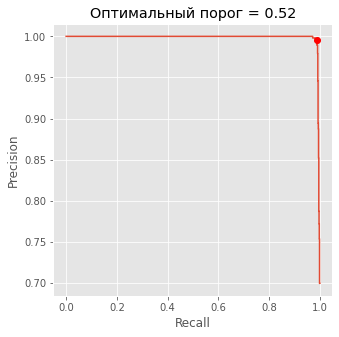

In [ ]:
get_scores_NN(model1, X_train, y_train)

ROC-AUC score: 1.00


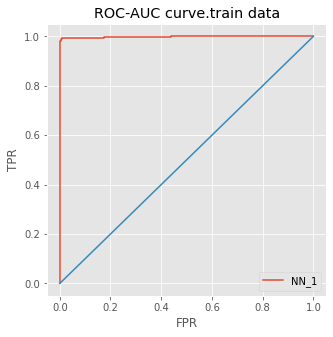

In [ ]:
get_roc_auc(y_train, model1.predict_proba(X_train)[:,0], 'NN_1', 'train data')

#### test data

Average precision_recall score: 0.89
ROC-AUC score: 0.89


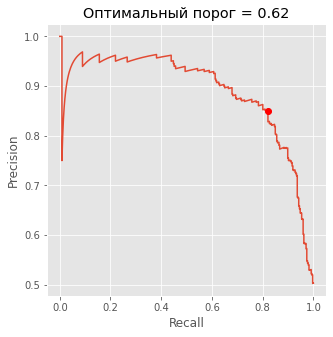

In [ ]:
get_scores_NN(model1, X_test, y_test)

ROC-AUC score: 0.89


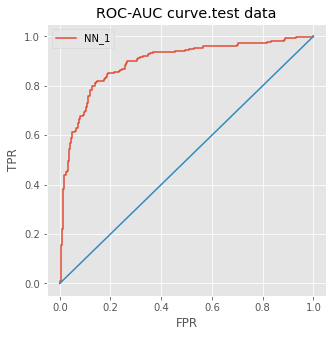

In [ ]:
get_roc_auc(y_test, model1.predict_proba(X_test)[:,0], 'NN_1', 'test data')

In [ ]:
# Сохраним vectorizer и сеть 
import pickle

with open(PATH+'/NN_28092020/vectorizer', 'wb') as fout:
    pickle.dump(vectorizer, fout)

model1.save(PATH+'/NN_28092020/NN_model_for_short_sntns.h5')

## Предсказание

In [ ]:
my_sentences = ['the match was great', 'it is the worst trip in my life']
d = vectorizer.transform(my_sentences).toarray()

In [ ]:
my_sentences

['the match was great', 'it is the worst trip in my life']

In [ ]:
model1.predict(d)[:, 0]

array([0.89733213, 0.08089016], dtype=float32)

In [ ]:
result = pd.DataFrame({'sentence': my_sentences, 
                      'result': model1.predict(d)[:, 0]
              })

In [ ]:
result

,sentence,result
0,the match was great,0.897332
1,it is the worst trip in my life,0.080890


## Кодирование с помощью Tokenizer

In [ ]:
from keras.preprocessing.text import Tokenizer

In [ ]:
df.shape

(2748, 3)

In [ ]:
tokenizer = Tokenizer(num_words=15000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1 

print(sentences_train[2])
print(X_train[2])

Works good.
[88, 18]


In [ ]:
for word in ['the', 'all', 'fan', 'film']:
  print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 30
fan: 780
film: 31


In [ ]:
# Обрезка векторов
## Далее нам нужно укоротить и проложить входные последовательности так, чтобы они были одинаковой длины для моделирования.

from keras.preprocessing.sequence import pad_sequences

In [ ]:
maxlen = 150

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[  55   10    4  160  570 1141    6  183    1  153  118  671   22    7
  110   44   80  161    1  672    9    1  192    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


#### Модель 2

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
from keras import layers

In [ ]:
embedding_dim = 50

model2 = Sequential()
model2.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model2.add(layers.Flatten())
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 50)           217050    
_________________________________________________________________
flatten (Flatten)            (None, 7500)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                75010     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 292,071
Trainable params: 292,071
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7962


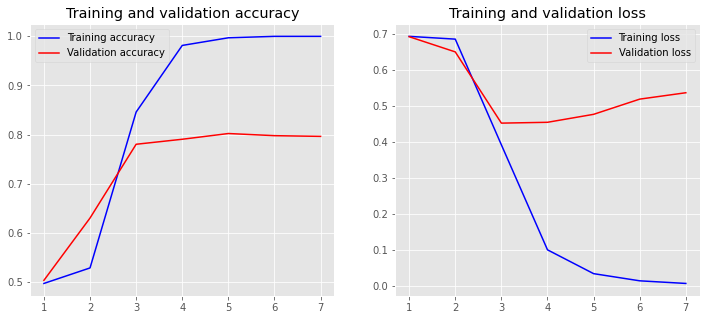

In [ ]:
history2 = model2.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                    callbacks=callbacks_list
                    )
loss, accuracy = model2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history2)

#### test data

Average precision_recall score: 0.88
ROC-AUC score: 0.88


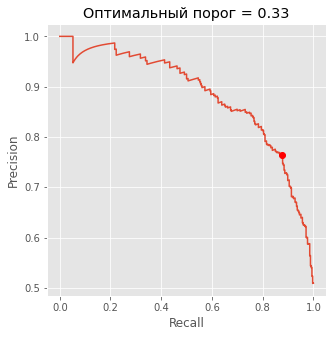

In [ ]:
get_scores_NN(model2, X_test, y_test)

ROC-AUC score: 0.88


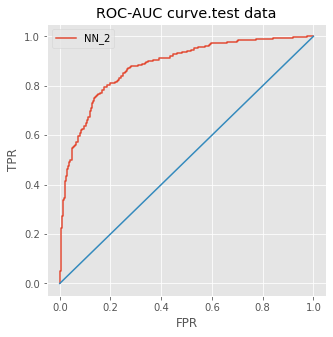

In [ ]:
get_roc_auc(y_test, model2.predict_proba(X_test)[:,0], 'NN_2', 'test data')

## Предсказание model 2

In [ ]:
my_sentences = ['the match was great', 'it is the worst trip in my life']
d = tokenizer.texts_to_sequences(my_sentences)

maxlen = 150
d = pad_sequences(d, padding='post', maxlen=maxlen)

In [ ]:
result_model_2 = pd.DataFrame({'sentence': my_sentences, 
                      'result': model2.predict(d)[:, 0]
              })

In [ ]:
result_model_2

,sentence,result
0,the match was great,0.973330
1,it is the worst trip in my life,0.015732


#### model 3 - Conv

In [ ]:
embedding_dim = 100

model3 = Sequential()
model3.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model3.add(layers.Conv1D(128, 5, activation='relu'))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(10, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          434100    
_________________________________________________________________
conv1d (Conv1D)              (None, 146, 128)          64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 499,529
Trainable params: 499,529
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9985
Testing Accuracy:  0.8355


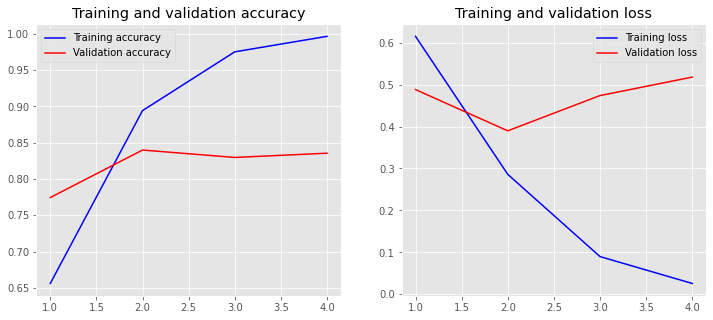

In [ ]:
history3 = model3.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                    callbacks=callbacks_list
                    )
loss, accuracy = model3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history3)

#### test data

Average precision_recall score: 0.90
ROC-AUC score: 0.90


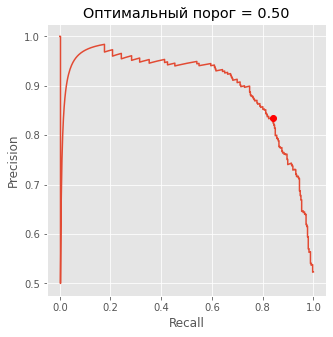

In [ ]:
get_scores_NN(model3, X_test, y_test)

ROC-AUC score: 0.90


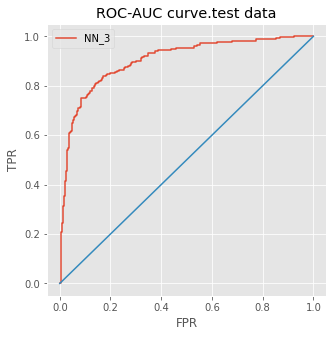

In [ ]:
get_roc_auc(y_test, model3.predict_proba(X_test)[:,0], 'NN_3', 'test data')

## Предсказание model 3

In [ ]:
# my_sentences = ['the match was great', 'it is the worst trip in my life']
# d = tokenizer.texts_to_sequences(my_sentences)

# maxlen = 150
# d = pad_sequences(d, padding='post', maxlen=maxlen)

In [ ]:
result_model_3 = pd.DataFrame({'sentence': my_sentences, 
                      'result': model3.predict(d)[:, 0]
              })

In [ ]:
result_model_3

,sentence,result
0,the match was great,0.916798
1,it is the worst trip in my life,0.004700


#### model 4 - RNN

In [ ]:
embedding_dim = 100

model4 = Sequential()
model4.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model4.add(layers.Dropout(0.2))   -- попробовать без них
model4.add(layers.LSTM(100))
model4.add(layers.Dropout(0.2))
model4.add(Dense(1, activation='sigmoid'))

model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model4.summary()

SyntaxError: ignored

In [ ]:
history4 = model4.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                    callbacks=callbacks_list
                    )
loss, accuracy = model4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history2)

#### test data

In [ ]:
get_scores_NN(model4, X_test, y_test)

In [ ]:
get_roc_auc(y_test, model4.predict_proba(X_test)[:,0], 'NN_4', 'test data')

## Предсказание model 4

In [ ]:
# my_sentences = ['the match was great', 'it is the worst trip in my life']
# d = tokenizer.texts_to_sequences(my_sentences)

# maxlen = 150
# d = pad_sequences(d, padding='post', maxlen=maxlen)

In [ ]:
result_model_4 = pd.DataFrame({'sentence': my_sentences, 
                      'result': model4.predict(d)[:, 0]
              })

In [ ]:
result_model_4

### Сравнительная таблица моделей

In [ ]:
res = pd.DataFrame({'Model': ['RandomForest', 'NN_1_perceptron', 'NN_2_Tokenizer', 'NN_3_Conv_Tokenizer', 'NN_4_RNN_Tokenizer'],
                   'ROC-AUC score': [0.84, 0.89, 0.88, 0.89, 0.5]}
                   )
res

## БД для русского языка - Юлия Рубцова nlp dataset

In [ ]:
PATH = "/content/drive/My Drive/Нейронные сети 1_Модуль_2020"

In [ ]:
filepath_dict2 = {'positive':   PATH+'/positive.csv',
                 'negative': PATH+'/negative.csv'
                 }

In [ ]:
filepath_dict2

label: 1 - positive, 0 - negative 

In [ ]:
df_pos = pd.read_csv('/content/drive/My Drive/Нейронные сети 1_Модуль_2020/positive.csv', sep=';', comment='#', header=None)
df_pos.columns = ['id', 'tdate', 'tname', 'ttext', 'ttype', 'trep', 'trtw', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount']
df_pos['label'] = 1
df_pos.head()

In [ ]:
df_neg = pd.read_csv('/content/drive/My Drive/Нейронные сети 1_Модуль_2020/negative.csv', sep=';', comment='#', header=None)
df_neg.columns = ['id', 'tdate', 'tname', 'ttext', 'ttype', 'trep', 'trtw', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount']
df_neg['label'] = 0
df_neg.head()

In [ ]:
import gc 
gc.collect()

In [ ]:
df2 = pd.concat([df_pos, df_neg], axis=0)
df2.head()

In [ ]:
df2.shape

Выделим только текст и значение тональности

In [ ]:
df2 = df2.loc[:, ['ttext', 'label']]
df2.head()

In [ ]:
df2.shape

In [ ]:
df2['label'].value_counts()

In [ ]:
 from string import ascii_letters

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
from nltk import word_tokenize

In [ ]:
def validate_token(value):
    return all(map(lambda c: c not in ascii_letters, value))

In [ ]:
def text_process(text):
       
    tokenized_text = word_tokenize(text, 'russian')
    
    # Удаление пунктуации и прочих символов
    no_punctuation = [token for token in tokenized_text if token.isalpha() and validate_token(token)]
    
    return ' '.join(no_punctuation).lower()

In [ ]:
# протестируем функцию
text_process('asd as d123134 машина')

In [ ]:
# Почистить столбец ttext
df2['ttext2'] = df2['ttext'].apply(text_process)
df2.head()

In [ ]:
sentences_rus = df2['ttext2'].values

In [ ]:
y_rus = df2['label'].values

In [ ]:
sentences_rus_train, sentences_rus_test, y_rus_train, y_rus_test = train_test_split(sentences_rus, y_rus, test_size=0.3, random_state=17)

### Классификатор RandomForest

In [ ]:
vectorizer_rus = CountVectorizer()
vectorizer_rus.fit(sentences_rus_train)

X_rus_train = vectorizer_rus.transform(sentences_rus_train)
X_rus_test  = vectorizer_rus.transform(sentences_rus_test)
X_rus_train

In [ ]:
rfc_cl_rus = RandomForestClassifier(random_state=17, max_depth=10)
rfc_cl_rus.fit(X_rus_train, y_rus_train)
score = rfc_cl_rus.score(X_rus_test, y_rus_test)

print("Accuracy:", score)

#### Графики модели

#### train data 

In [ ]:
get_scores(rfc_cl_rus, X_rus_train, y_rus_train)

In [ ]:
get_conf_matrix(y_rus_train, rfc_cl_rus.predict(X_rus_train))

In [ ]:
get_roc_auc(y_rus_train, rfc_cl_rus.predict_proba(X_rus_train)[:,1], 'random forest', 'train data')

#### test data

In [ ]:
get_scores(rfc_cl_rus, X_rus_test, y_rus_test)

In [ ]:
get_conf_matrix(y_rus_test, rfc_cl_rus.predict(X_rus_test))

In [ ]:
get_roc_auc(y_rus_test, rfc_cl_rus.predict_proba(X_rus_test)[:,1], 'random forest', 'test data')

## Предсказание Random Forest

In [ ]:
my_sentences_rus = ['лучший игрок', 'очень плохой фильм']
d = vectorizer_rus.transform(my_sentences_rus).toarray()

In [ ]:
result_rfr_rus = pd.DataFrame({'sentence': my_sentences_rus, 
                      'result': rfc_cl_rus.predict(d)
              })

In [ ]:
result_rfr_rus

плохой классификатор

In [ ]:
df2.shape

### НС 1

In [ ]:
input_dim_rus = X_rus_train.shape[1]

model1_rus = Sequential()
model1_rus.add(Dense(10, input_dim=input_dim_rus, activation='relu'))
model1_rus.add(Dense(1, activation='sigmoid'))

In [ ]:
model1_rus.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
model1_rus.summary()

In [ ]:
history_rus = model1_rus.fit(X_rus_train, y_rus_train, 
                    epochs=20,
                    verbose=True,
                    validation_data=(X_rus_test, y_rus_test),
                    batch_size=1000,
                    callbacks=callbacks_list)

## Результаты

In [ ]:
# Plot training & validation accuracy values
plt.plot(history_rus.history['accuracy'])
plt.plot(history_rus.history['val_accuracy']) 
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_rus.history['loss'])
plt.plot(history_rus.history['val_loss'])  
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model1_rus.evaluate(X_rus_train, y_rus_train, verbose=False)
print("Training Accuracy: {:.4}".format(accuracy))
loss, accuracy = model1_rus.evaluate(X_rus_test, y_rus_test, verbose=False)
print("Test Accuracy: {:.4}".format(accuracy))

In [ ]:
def get_scores_NN(model, X, y): 
  y_pred = model.predict_proba(X)[:,0]
  p_score, r_score, thresholds = precision_recall_curve(y, y_pred)
  f_score = (2 * p_score * r_score) / (p_score + r_score)
  idx = np.argmax(f_score)
  threshold = thresholds[idx]

  plt.figure(figsize=(5,5))
  plt.plot(r_score, p_score)
  plt.plot(r_score[idx], p_score[idx], marker=".", markersize=12, color='r')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  t = plt.title('Оптимальный порог = {:.2f}'.format(threshold))

  print('Average precision_recall score: {:.2f}'.format(average_precision_score(y, y_pred)))
  print('ROC-AUC score: {:.2f}'.format(roc_auc_score(y, y_pred)))

In [ ]:
def get_roc_auc_NN(y, y_pred_proba, model_name, data_type):
  plt.figure(figsize=(5,5)) 
  fpr, tpr, _ = roc_curve(y, y_pred_proba)
  plt.plot(fpr, tpr, label=model_name)
  plt.plot([0,1], [0,1])
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.legend()
  t = plt.title('ROC-AUC curve.'+data_type)

  print('ROC-AUC score: {:.2f}'.format(roc_auc_score(y, y_pred_proba)))

#### train data 

In [ ]:
get_scores_NN(model1_rus, X_rus_train, y_rus_train)

In [ ]:
get_roc_auc(y_rus_train, model1_rus.predict_proba(X_rus_train)[:,0], 'NN_1', 'train_rus data')

#### test data

In [ ]:
get_scores_NN(model1_rus, X_rus_test, y_rus_test)

In [ ]:
get_roc_auc(y_rus_test, model1_rus.predict_proba(X_rus_test)[:,0], 'NN_1', 'test data')

## Предсказание

In [ ]:
my_sentences_rus = ['Погода вчера была потрясающая', 'Ты плохо сегодня сыграл']
d = vectorizer_rus.transform(my_sentences_rus).toarray()

In [ ]:
model1_rus.predict(d)[:, 0]

In [ ]:
result_rus = pd.DataFrame({'sentence': my_sentences_rus, 
                      'result_proba': model1_rus.predict(d)[:, 0]
              })
result_rus['result'] = round(result_rus['result_proba'],0)

result_rus['result_name'] = " Позитивное"
result_rus.loc[(result_rus['result'] == 0.0), 'result_name'] = "Негативное"

result_rus